In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import torch

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from torchvision import datasets



## Fashion MNIST dataset


In [2]:
def get_fmnist_data():
    data_dir = './data/non-parametric/'
    train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True)
    test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True)

    X_train, y_train= train_dataset.train_data,train_dataset.train_labels
    X_test, y_test = test_dataset.test_data,test_dataset.test_labels
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

### Neural Network

In [3]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)  ##本来是16*5*5，mnist改为16*4*4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.Tensor(x).view(-1, 1, 28, 28).type(torch.float32)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        # return self.sm(x)
    
    def predict(self, x):
        output = self.forward(x)
        output = output.data.max(1, keepdim=True)[1]
        return output.reshape(-1)


## Create the graph data

Here we have a test dataset that is a comobination of the text datasets from both pima and cancer datasets mentioned above. Additionally, the features for each node of a graph is a random combination of these two datasets. For each node $i$, we first select a random number $r \in [15, 85]$ and then we randomly select $r$% of the pima dataset and $(100-r)$% of the cancer dataset as the train dataset for the node $i$.

Finally, the similarity score between nodes $i$ and $j$ is calculated based on the number of similar datapoint that they have in their training sets.

In [4]:
def get_graph():
    X_train, y_train, X_test, y_test = get_fmnist_data()
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    X_train = X_train.reshape(X_train.shape[0], 28*28)
    X_test = X_test.reshape(X_test.shape[0], 28*28)
    
    
    first_train = np.where(y_train < 2)[0]
    first_X_train = X_train[first_train]
    first_y_train = y_train[first_train]
    
    second_train = np.where((y_train >= 2) & (y_train < 4))[0]
    second_X_train = X_train[second_train]
    second_y_train = y_train[second_train]
    
    # combine the both clusters' test datasets
    first_test = np.where(y_test < 2)[0]
    first_X_test = X_test[first_test]
    first_y_test = y_test[first_test]

    
    second_test = np.where((y_test >= 2) & (y_test < 4))[0]
    second_X_test = X_test[second_test]
    second_y_test = y_test[second_test]
    
    X_test = np.concatenate((first_X_test, second_X_test))
    y_test = np.concatenate((first_y_test, second_y_test))
    
    # 
    data_len = len(first_X_train)
    datapoints = {}
    N = 20
    node_indices = []
    for n in range(N):
        # select a random number  0.25 < r < 0.75
        # r = random.random()
        # while r < 0.15 or r > 0.85:
        #     r = random.random()
        if n < N//2:
          r = 0.3
        else:
          r = 0.7
            
        # uniformly select r% of the data from pima dataset
        node_idx1 = random.sample([i for i in range(data_len)], int(data_len*r)) 
        node_pima_x = first_X_train[node_idx1]
        node_pima_y = first_y_train[node_idx1]
        
        # uniformly select (1-r)% of the data from cancer dataset
        node_idx2 = random.sample([i for i in range(data_len)], int(data_len*(1-r))) 
        node_cancer_x = second_X_train[node_idx2]
        node_cancer_y = second_y_train[node_idx2]
        
        node_x = np.concatenate((node_pima_x, node_cancer_x))
        node_y = np.concatenate((node_pima_y, node_cancer_y))
        node_idx = random.sample([i for i in range(len(node_x))], int(len(node_x)*0.4))
        node_x = node_x[node_idx]
        node_y = node_y[node_idx]
        
        # model = LogisticRegression(multi_class='multinomial')
        if n < N//2:
            model = DecisionTreeClassifier(criterion='log_loss')
            model_type = 'DT'
            optimizer = None
            loss = None
        else:
            model = LeNet()
            model_type = 'NN'
            # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
            loss = nn.NLLLoss()
        
        # node_indices.append((node_idx1, node_idx2))
        node_indices.append(r)
        datapoints[n] = {
            'features': node_x,
            'all_features': node_x,
            'labels': node_y,
            'all_labels': node_y,
            'sample_weights': np.ones(len(node_idx)),
            'model': model,
            'optimizer': optimizer,
            'model_type': model_type,
            'loss': loss,
        }

        
    # calculate the similarities between nodes
    E = N * (N-1)//2
    B = np.zeros((E, N))
    weight_vec = np.zeros(E)
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            r1 = node_indices[i]
            r2 = node_indices[j]
            weight_vec[cnt] = min(r1, r2) + min((1-r1), (1-r2))
            B[cnt, i] = 1
            B[cnt, j] = -1
            cnt += 1
            
    return B, weight_vec, datapoints, X_test, y_test

            


## Algorithm


In [5]:
def algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=1.0, K=100):
    test_len = len(X_test)
    train_batch_size = 500
    
    iter_scores = []
    for k in range(K):
        print(k)
        
        # fit the model for each node
        for node in datapoints:
            if datapoints[node]['model_type'] == 'DT':
                clf = datapoints[node]['model']
                clf = clf.fit(datapoints[node]['all_features'], datapoints[node]['all_labels'], 
                              sample_weight=datapoints[node]['sample_weights'])
                datapoints[node]['model'] = clf
            elif datapoints[node]['model_type'] == 'NN':
                network = datapoints[node]['model']
                optimizer = datapoints[node]['optimizer']
                # loss_func = datapoints[node]['loss']
                # network.train()
                n_data = len(datapoints[node]['all_features'])
                for batch_idx in range(n_data//train_batch_size):
                    optimizer.zero_grad()

                    splited_data = np.array(datapoints[node]['all_features'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
                    splited_target = np.array(datapoints[node]['all_labels'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
                    splited_target = torch.Tensor(splited_target).type(torch.LongTensor)
                    
                    output = network(splited_data)
                    # loss = loss_func(output, splited_target)
                    loss = nn.NLLLoss()(output, splited_target)
                    # if node == 19:
                    #     y_pred = network.predict(X_test)
                    #     output = network.predict(splited_data)
                    #     print(len(datapoints[node]['all_features']), batch_idx, loss, metrics.accuracy_score(y_test, y_pred),
                    #            metrics.accuracy_score(splited_target, output))
                    loss.backward()
                    optimizer.step()
                # datapoints[node]['optimizer'] = optimizer
                # datapoints[node]['model'] = network
                # datapoints[node]['loss'] = loss_func

        # calculate the accuracy for each node
        accs = []
        for node in datapoints:
            clf = datapoints[node]['model']
            y_pred = clf.predict(X_test)
            accs.append(metrics.accuracy_score(y_test, y_pred))
            if node == 19 or node == 0:
              print(node, metrics.accuracy_score(y_test, y_pred))
            # y_pred = clf.predict(datapoints[node]['features'])
            # accs.append(metrics.accuracy_score(datapoints[node]['labels'], y_pred))
        iter_scores.append(accs)

        # combine the test predictions for the adjancents node of each node
        for node in datapoints:
            datapoints[node]['all_features'] = [datapoints[node]['features']]
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['labels']))
            for B_neigh in np.where(B[:, node] != 0)[0]:
                w = weight_vec[B_neigh]
                for neigh in np.where(B[B_neigh, :] != 0)[0]:
                    if neigh == node:
                        continue
                    data_idx = random.sample([i for i in range(test_len)], int(test_len*w)) 
                    # data_idx = random.sample([i for i in range(test_len)], int(test_len*w*0.3)) 
                    selected_x_test = X_test[data_idx]
                    datapoints[node]['all_features'].append(selected_x_test)
                    y_pred = datapoints[neigh]['model'].predict(selected_x_test)
                    datapoints[node]['all_labels'] = np.concatenate(
                        (datapoints[node]['all_labels'], y_pred))
                    _sample_weights = [lambda_lasso/2.0 for _ in range(len(y_pred))]
                    datapoints[node]['sample_weights'] = np.concatenate(
                        (datapoints[node]['sample_weights'], _sample_weights))

            datapoints[node]['all_features'] = np.concatenate(datapoints[node]['all_features'])
            shuffled = [i for i in range(len(datapoints[node]['all_features']))]
            random.shuffle(shuffled)
            datapoints[node]['all_features'] = datapoints[node]['all_features'][shuffled]
            datapoints[node]['all_labels'] = datapoints[node]['all_labels'][shuffled]
            datapoints[node]['sample_weights'] = datapoints[node]['sample_weights'][shuffled]


    iter_scores = np.array(iter_scores)
    
    return iter_scores

In [6]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

K = 50
# K=5
# # federated learning accuracies
iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=2.0, K=K)
print('pass alg1')

N = len(datapoints)
train_batch_size = 500
# Individual accuracies
for node in datapoints:
    model = LeNet()
    model_type = 'NN'
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    if node < N//2:
        model = DecisionTreeClassifier(criterion='log_loss')
        model_type = 'DT'
        optimizer = None
    datapoints[node]['model'] = model
    datapoints[node]['model_type'] = model_type
    datapoints[node]['optimizer'] = optimizer

single_iter_scores = []
for k in range(K):
    print(k)
    for node in datapoints:
        if datapoints[node]['model_type'] == 'DT':
                clf = datapoints[node]['model']
                clf = clf.fit(datapoints[node]['features'], datapoints[node]['labels'])
                datapoints[node]['model'] = clf
        elif datapoints[node]['model_type'] == 'NN':
          network = datapoints[node]['model']
          optimizer = datapoints[node]['optimizer']
          # loss_func = datapoints[node]['loss']
          # network.train()
          n_data = len(datapoints[node]['features'])
          for batch_idx in range(n_data//train_batch_size):
              optimizer.zero_grad()

              splited_data = np.array(datapoints[node]['features'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
              splited_target = np.array(datapoints[node]['labels'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
              splited_target = torch.Tensor(splited_target).type(torch.LongTensor)
              
              output = network(splited_data)
              # loss = loss_func(output, splited_target)
              loss = nn.NLLLoss()(output, splited_target)
              loss.backward()
              optimizer.step()
            
    accs = []
    for node in datapoints:
        clf = datapoints[node]['model']
        y_pred1 = clf.predict(X_test)
        accs.append(metrics.accuracy_score(y_test, y_pred1))
        if node == 0 or node ==19:
          print(node, metrics.accuracy_score(y_test, y_pred1))
        # y_pred = clf.predict(datapoints[node]['features'])
        # accs.append(metrics.accuracy_score(datapoints[node]['labels'], y_pred))
    single_iter_scores.append(accs)
    
    
single_iter_scores = np.array(single_iter_scores)


100%|██████████| 26421880/26421880 [00:01<00:00, 15931044.69it/s]


Extracting ./data/non-parametric/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/non-parametric/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 223351.24it/s]


Extracting ./data/non-parametric/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/non-parametric/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4945706.33it/s]


Extracting ./data/non-parametric/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/non-parametric/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1193141.24it/s]
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Extracting ./data/non-parametric/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/non-parametric/FashionMNIST/raw

0
0 0.89175
19 0.25
1
0 0.926
19 0.633
2
0 0.92475
19 0.90225
3
0 0.92225
19 0.8905
4
0 0.91975
19 0.91175
5
0 0.9195
19 0.92675
6
0 0.91825
19 0.9225
7
0 0.918
19 0.927
8
0 0.91875
19 0.926
9
0 0.918
19 0.919
10
0 0.918
19 0.9255
11
0 0.918
19 0.92275
12
0 0.91825
19 0.92
13
0 0.918
19 0.9195
14
0 0.918
19 0.919
15
0 0.918
19 0.91875
16
0 0.918
19 0.9175
17
0 0.918
19 0.919
18
0 0.918
19 0.9185
19
0 0.918
19 0.918
20
0 0.918
19 0.9185
21
0 0.918
19 0.91825
22
0 0.918
19 0.918
23
0 0.918
19 0.918
24
0 0.918
19 0.918
25
0 0.918
19 0.918
26
0 0.918
19 0.918
27
0 0.918
19 0.91775
28
0 0.918
19 0.918
29
0 0.918
19 0.91775
30
0 0.918
19 0.918
31
0 0.918
19 0.918
32
0 0.918
19 0.91825
33
0 0.918
19 0.918
34
0 0.918
19 0.91825
35
0 0.918
19 0.91825
36
0 0.918
19 0.9185
37
0 0.918
19 0.91725
38
0 0.918
19 0.918
39
0 0.918
19 0.9175
40
0 0.918
19 0.918
41
0 0.918
19 0.918
42
0 

In [7]:
N = len(datapoints)
train_batch_size = 700
# Individual accuracies
for node in datapoints:
    model = LeNet()
    model_type = 'NN'
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    if node < N//2:
        model = DecisionTreeClassifier(criterion='log_loss')
        model_type = 'DT'
        optimizer = None
    datapoints[node]['model'] = model
    datapoints[node]['model_type'] = model_type
    datapoints[node]['optimizer'] = optimizer

single_iter_scores = []
for k in range(K):
    print(k)
    for node in datapoints:
        if datapoints[node]['model_type'] == 'DT':
                clf = datapoints[node]['model']
                clf = clf.fit(datapoints[node]['features'], datapoints[node]['labels'])
                datapoints[node]['model'] = clf
        elif datapoints[node]['model_type'] == 'NN':
          network = datapoints[node]['model']
          optimizer = datapoints[node]['optimizer']
          # loss_func = datapoints[node]['loss']
          # network.train()
          n_data = len(datapoints[node]['features'])
          for batch_idx in range(n_data//train_batch_size):
              optimizer.zero_grad()

              splited_data = np.array(datapoints[node]['features'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
              splited_target = np.array(datapoints[node]['labels'][batch_idx*train_batch_size:(batch_idx+1)*train_batch_size])
              splited_target = torch.Tensor(splited_target).type(torch.LongTensor)
              
              output = network(splited_data)
              # loss = loss_func(output, splited_target)
              loss = nn.NLLLoss()(output, splited_target)
              loss.backward()
              optimizer.step()
            
    accs = []
    for node in datapoints:
        clf = datapoints[node]['model']
        y_pred1 = clf.predict(X_test)
        accs.append(metrics.accuracy_score(y_test, y_pred1))
        if node == 0 or node ==19:
          print(node, metrics.accuracy_score(y_test, y_pred1))
        # y_pred = clf.predict(datapoints[node]['features'])
        # accs.append(metrics.accuracy_score(datapoints[node]['labels'], y_pred))
    single_iter_scores.append(accs)
    
    
single_iter_scores = np.array(single_iter_scores)


0
0 0.88925
19 0.25
1
0 0.894
19 0.25
2
0 0.8905
19 0.25125
3
0 0.889
19 0.457
4
0 0.891
19 0.32175
5
0 0.89125
19 0.28775
6
0 0.895
19 0.3455
7
0 0.89175
19 0.424
8
0 0.89225
19 0.46075
9
0 0.8935
19 0.46875
10
0 0.8895
19 0.3095
11
0 0.89
19 0.4715
12
0 0.89325
19 0.3715
13
0 0.894
19 0.4745
14
0 0.89575
19 0.48175
15
0 0.88925
19 0.7455
16
0 0.8945
19 0.52
17
0 0.893
19 0.83075
18
0 0.8925
19 0.7595
19
0 0.8935
19 0.86525
20
0 0.89375
19 0.871
21
0 0.89225
19 0.8755
22
0 0.896
19 0.88
23
0 0.895
19 0.88275
24
0 0.89225
19 0.88475
25
0 0.89
19 0.8875
26
0 0.888
19 0.88775
27
0 0.894
19 0.887
28
0 0.892
19 0.8875
29
0 0.89425
19 0.89
30
0 0.8895
19 0.89125
31
0 0.8935
19 0.8915
32
0 0.89225
19 0.8915
33
0 0.89275
19 0.89175
34
0 0.892
19 0.89275
35
0 0.8925
19 0.89375
36
0 0.897
19 0.89325
37
0 0.8935
19 0.8935
38
0 0.89175
19 0.894
39
0 0.8935
19 0.8955
40
0 0.89125
19 0.89575
41
0 0.89225
19 0.89675
42
0 0.89125
19 0.89675
43
0 0.89025
19 0.8965
44
0 0.896
19 0.8965
45
0 0.89275
19 

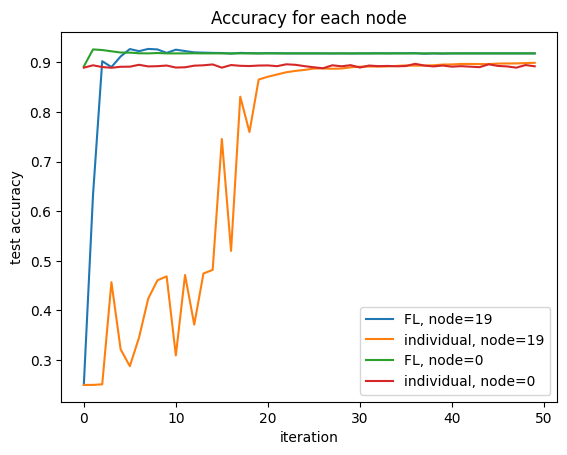

In [8]:
f = plt.figure()
x = [i for i in range(K)]
# x = [i for i in range(15)]
for node in [19, 0]:
    plt.plot(x, iter_scores[:, node][:len(x)], label='FL, node=' + str(node))
    plt.plot(x, single_iter_scores[:, node][:len(x)], label='individual, node=' + str(node))
plt.title('Accuracy for each node')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
plt.close()

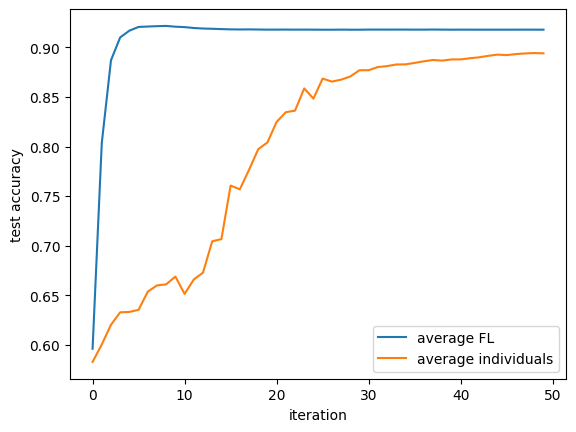

In [9]:
f = plt.figure()
x = [i for i in range(K)]
# x = [i for i in range(15)]
fl_mean_acc = np.mean(iter_scores, axis=1)[:len(x)]
single_mean_acc = np.mean(single_iter_scores, axis=1)[:len(x)]
plt.plot(x, fl_mean_acc, label='average FL')
plt.plot(x, single_mean_acc, label='average individuals')

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/fmnist_fl_vs_individual_different.pdf", bbox_inches='tight')
plt.close()

In [ ]:
# B, weight_vec, datapoints, X_test, y_test = get_graph()

# K = 15
# # federated learning accuracies
# iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=0.0, K=K)
# print('pass alg1')

# # Individual accuracies
# for node in datapoints:
#     datapoints[node]['model'] = DecisionTreeClassifier()

# single_iter_scores = []
# for k in range(K):
#     for node in datapoints:
#         clf = datapoints[node]['model']
#         clf = clf.fit(datapoints[node]['features'], datapoints[node]['labels'])
#         datapoints[node]['model'] = clf
        
#     accs = []
#     for node in datapoints:
#         clf = datapoints[node]['model']
#         y_pred1 = clf.predict(X_test)
#         accs.append(metrics.accuracy_score(y_test, y_pred1))
#     single_iter_scores.append(accs)
    
    
# single_iter_scores = np.array(single_iter_scores)


In [1]:
# f = plt.figure()
# x = [i for i in range(K)]
# x = [i for i in range(15)]
# for node in datapoints:
#     plt.plot(x, iter_scores[:, node][:len(x)], label='FL, node=' + str(node))
#     plt.plot(x, single_iter_scores[:, node][:len(x)], label='individual, node=' + str(node))
#     if node > 0:
#         break
# plt.title('Accuracy for each node')
# plt.xlabel('iteration')
# plt.ylabel('test accuracy')
# # plt.yscale("log")
# plt.legend()
# plt.show()
# plt.close()

In [2]:
# f = plt.figure()
# x = [i for i in range(K)]
# x = [i for i in range(15)]
# fl_mean_acc = np.mean(iter_scores, axis=1)[:len(x)]
# single_mean_acc = np.mean(single_iter_scores, axis=1)[:len(x)]
# plt.plot(x, fl_mean_acc, label='average FL')
# plt.plot(x, single_mean_acc, label='average individuals')

# # plt.title('Mean accuracy for all the nodes')
# plt.xlabel('iteration')
# plt.ylabel('test accuracy')
# # plt.yscale("log")
# plt.legend()
# plt.show()
# # f.savefig("./data/non-parametric/fl_vs_individual.pdf", bbox_inches='tight')
# plt.close()

In [10]:
import json

fl_vs_individual_data = {
    'fl_mean_acc': list(fl_mean_acc),
    'individual_mean_acc': list(single_mean_acc),
}

import pandas as pd
  
data = [[i, fl_mean_acc[i], single_mean_acc[i]] for i in range(15)]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['iter', 'fl_mean', 'individual_mean'])

with open('./data/non-parametric/fmnist_fl_vs_individual.json', 'w') as f:
    f.write(json.dumps(fl_vs_individual_data))
    
df.to_csv('./data/non-parametric/fmnist_fl_vs_individual.csv')